In [2]:
!pip install seaborn plotly


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime, timedelta

In [4]:
from google.colab import files
uploaded = files.upload()

Saving script.js to script.js


In [5]:
!pip install js2py


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 14.3 MB/s eta 0:00:00
  Created wheel for pyjsparser: filename=pyjsparser-2.7.1-py3-none-any.whl size=25982 sha256=4a845a3afba61a7072da137228df604264ac75e5e100756be439dd5e37e559af
  Stored in directory: /root/.cache/pip/wheels/a5/9a/30/1003e89ab4555b81840ca46d361bf184f1e6ad880cae3b62a9
Successfully built pyjsparser


In [6]:
import re
import json
import pandas as pd

# Load your JS file
with open('/content/script.js', 'r') as file:
    content = file.read()

# Remove JS comments
content = re.sub(r'//.*', '', content)

# Try multiple patterns: this one works even if no semicolon
match = re.search(r'ticketsData\s*=\s*(\[[\s\S]+?\])', content)
if not match:
    raise ValueError("Couldn't extract the ticketsData array.")

array_str = match.group(1)




In [7]:
array_str = re.sub(r'(\w+):', r'"\1":', array_str)  # Convert keys to strings
array_str = array_str.replace("'", '"')             # Single to double quotes
array_str = array_str.replace("true", "true").replace("false", "false").replace("null", "null")
array_str = re.sub(r',(\s*[}\]])', r'\1', array_str)  # Remove trailing commas

In [8]:
!pip install json5

In [9]:
import re
import json5
import pandas as pd

# Step 1: Read the script file
with open('/content/script.js', 'r') as file:
    content = file.read()

# Step 2: Extract the content starting from 'ticketsData = [' to the closing ']'
start_index = content.find("ticketsData = [")
if start_index == -1:
    raise ValueError("Couldn't find the 'ticketsData' declaration.")

# Find the start of array
array_start = content.find("[", start_index)
bracket_count = 0
end_index = -1

# Step 3: Match brackets to find full array
for i in range(array_start, len(content)):
    if content[i] == "[":
        bracket_count += 1
    elif content[i] == "]":
        bracket_count -= 1
        if bracket_count == 0:
            end_index = i
            break

if end_index == -1:
    raise ValueError("Couldn't match closing bracket for 'ticketsData'.")

array_str = content[array_start:end_index + 1]

# Step 4: Parse using json5
try:
    tickets = json5.loads(array_str)
    df = pd.DataFrame(tickets)
    display(df.head())  # or print(df.head())
except Exception as e:
    print("❌ JSON5 parsing failed:", e)
    print("\n🔍 Data preview:\n", array_str[:500])


,id,summary,status,urgency,assignee,assigneeInitials,resolutionTime,tags,isDead,description,predictedTeam,estimatedDuration,classification,affectedArea,longResolution
0,TCK-1234,User authentication failing on mobile devices,development,critical,John Doe,JD,~6h,"[Backend, Bug]",False,Users are unable to log in through the mobile ...,Backend Development,~6 hours,"Critical Impact, High Urgency",User Authentication,True
1,TCK-1235,Dashboard loading performance issues,review,high,Jane Smith,JS,~4h,"[Frontend, Performance]",False,The main dashboard takes over 10 seconds to lo...,Frontend Development,~4 hours,"High Impact, Medium Urgency",Dashboard Performance,False
2,TCK-1236,Email notifications not being sent,test,medium,Mike Johnson,MJ,~3h,"[Backend, Email]",False,System email notifications for password resets...,Backend Development,~3 hours,"Medium Impact, Medium Urgency",Email Service,False
3,TCK-1237,UI inconsistencies in dark mode,defined,low,Sarah Wilson,SW,~2h,"[UX, Frontend]",False,Several UI components do not properly adapt to...,Frontend Development,~2 hours,"Low Impact, Low Urgency",User Interface,False
4,TCK-1238,Database connection timeout,completed,critical,Tom Brown,TB,~8h,"[Backend, Database]",False,Application experiencing frequent database con...,Backend Development,~8 hours,"Critical Impact, High Urgency",Database Connectivity,True


In [10]:
# Set plot style
sns.set(style="whitegrid")
%matplotlib inline

In [11]:
df['status'] = df['status'].str.title()  # 'defined' → 'Defined'

# Convert estimated duration to numeric hours
df['hours'] = df['estimatedDuration'].str.extract(r'~?(\d+)', expand=False).astype(float)

# Simulate a fake "created_at" timestamp for visualization (optional if not present)
# We'll distribute them evenly from Jan 1, 2024
df['created_at'] = pd.date_range(start="2024-01-01", periods=len(df), freq="D")

# Optional: If you want to analyze by urgency levels
urgency_order = ['low', 'medium', 'high', 'critical']
df['urgency'] = pd.Categorical(df['urgency'], categories=urgency_order, ordered=True)

# Convert status to proper title casing for better plotting
df['status'] = df['status'].str.title()

# Ready for visualization
print(df[['id', 'status', 'urgency', 'created_at', 'hours']].head())

         id       status   urgency created_at  hours
0  TCK-1234  Development  critical 2024-01-01    6.0
1  TCK-1235       Review      high 2024-01-02    4.0
2  TCK-1236         Test    medium 2024-01-03    3.0
3  TCK-1237      Defined       low 2024-01-04    2.0
4  TCK-1238    Completed  critical 2024-01-05    8.0


In [12]:
import plotly.graph_objects as go

# Count statuses
status_counts = df['status'].value_counts().reset_index()
status_counts.columns = ['Status', 'Count']

# Update your color mapping based on actual statuses
color_map = {
    'Defined': '#7f8c8d',       # Gray
    'Development': '#3498db',   # Blue
    'Review': '#f39c12',        # Orange
    'Test': '#9b59b6',          # Purple
    'Completed': '#2ecc71',     # Green
    'Accepted': '#1abc9c'       # Teal
}

# Create bar chart
fig1 = go.Figure()

for i, row in status_counts.iterrows():
    fig1.add_trace(go.Bar(
        x=[row['Status']],
        y=[row['Count']],
        name=row['Status'],
        marker_color=color_map.get(row['Status'], '#95a5a6'),  # fallback gray
        text=[row['Count']],
        textposition='outside',
        marker=dict(line=dict(width=1, color='white')),
        width=0.5
    ))

fig1.update_layout(
    title='📊 Ticket Status Distribution',
    xaxis_title=None,
    yaxis_title='Number of Tickets',
    template='plotly_white',
    showlegend=False,
    bargap=0.4,
    font=dict(family="Segoe UI, sans-serif", size=14),
    margin=dict(l=20, r=20, t=50, b=40)
)

fig1.update_traces(marker_line_width=1.2, opacity=0.85)

fig1.show()


In [13]:
import plotly.express as px

# Ensure 'created_at' is a datetime column
df['created_at'] = pd.to_datetime(df['created_at'])

# Group by date and count tickets
created_per_day = df.groupby(df['created_at'].dt.date).size().reset_index(name='Tickets Created')
created_per_day = created_per_day.sort_values('created_at')

# Plot area chart
fig2 = px.area(
    created_per_day,
    x='created_at',
    y='Tickets Created',
    title='📈 Tickets Created Over Time',
    markers=True,
    color_discrete_sequence=['#00b894']  # Customize color here
)

# Style the chart
fig2.update_layout(
    xaxis_title="Date",
    yaxis_title="Number of Tickets",
    template='plotly_white',
    font=dict(family="Segoe UI, sans-serif", size=14),
    margin=dict(l=20, r=20, t=50, b=40)
)

fig2.show()


In [14]:
import plotly.express as px
import pandas as pd
from datetime import timedelta

# Ensure datetime format
df['created_at'] = pd.to_datetime(df['created_at'])

# Simulate resolved_at = created_at + hours (as timedelta)
df['resolved_at'] = df['created_at'] + pd.to_timedelta(df['hours'], unit='h')

# Extract resolved date
df['resolved_date'] = df['resolved_at'].dt.date

# Group and count resolutions per day
resolved_per_day = df.groupby('resolved_date').size().reset_index(name='Tickets Resolved')
resolved_per_day = resolved_per_day.sort_values('resolved_date')

# Plot the chart
fig3 = px.area(
    resolved_per_day,
    x='resolved_date',
    y='Tickets Resolved',
    title='✅ Tickets Resolved Over Time',
    markers=True,
    color_discrete_sequence=['#0984e3']  # Customize color
)

# Style
fig3.update_layout(
    xaxis_title="Date",
    yaxis_title="Tickets",
    template='plotly_white',
    font=dict(family="Segoe UI, sans-serif", size=14),
    margin=dict(l=20, r=20, t=50, b=40)
)

fig3.show()


In [15]:
import plotly.graph_objects as go

In [16]:
import plotly.express as px
import pandas as pd

# Ensure datetime format
df['created_at'] = pd.to_datetime(df['created_at'])
df['resolved_at'] = df['created_at'] + pd.to_timedelta(df['hours'], unit='h')

# Extract weekly bucket (week starting)
df['created_week'] = df['created_at'].dt.to_period('W').apply(lambda r: r.start_time)
df['resolved_week'] = df['resolved_at'].dt.to_period('W').apply(lambda r: r.start_time)

# Count tickets created and resolved per week
created_weekly = df.groupby('created_week').size().reset_index(name='Tickets Created')
resolved_weekly = df.groupby('resolved_week').size().reset_index(name='Tickets Resolved')

# Merge both counts on week
timeline_df = pd.merge(created_weekly, resolved_weekly, left_on='created_week', right_on='resolved_week', how='outer')

# Fill missing values with 0 and unify week column
timeline_df['Week'] = timeline_df['created_week'].combine_first(timeline_df['resolved_week'])
timeline_df = timeline_df[['Week', 'Tickets Created', 'Tickets Resolved']].fillna(0)

# Melt into long format
bar_df = timeline_df.melt(
    id_vars='Week',
    value_vars=['Tickets Created', 'Tickets Resolved'],
    var_name='Metric',
    value_name='Count'
)

# Create grouped bar chart
fig6 = px.bar(
    bar_df,
    x='Week',
    y='Count',
    color='Metric',
    barmode='group',
    title='📅 Weekly Created vs Resolved Tickets',
    labels={'Week': 'Week Starting'},
    color_discrete_map={
        'Tickets Created': '#0984e3',
        'Tickets Resolved': '#00b894'
    }
)

fig6.update_layout(
    xaxis_title='Week',
    yaxis_title='Number of Tickets',
    legend_title='',
    bargap=0.2,
    template='plotly_white',
    font=dict(family="Segoe UI, sans-serif", size=14),
    hovermode='x unified'
)

fig6.show()


<ipython-input-17-2170437698>:6: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior



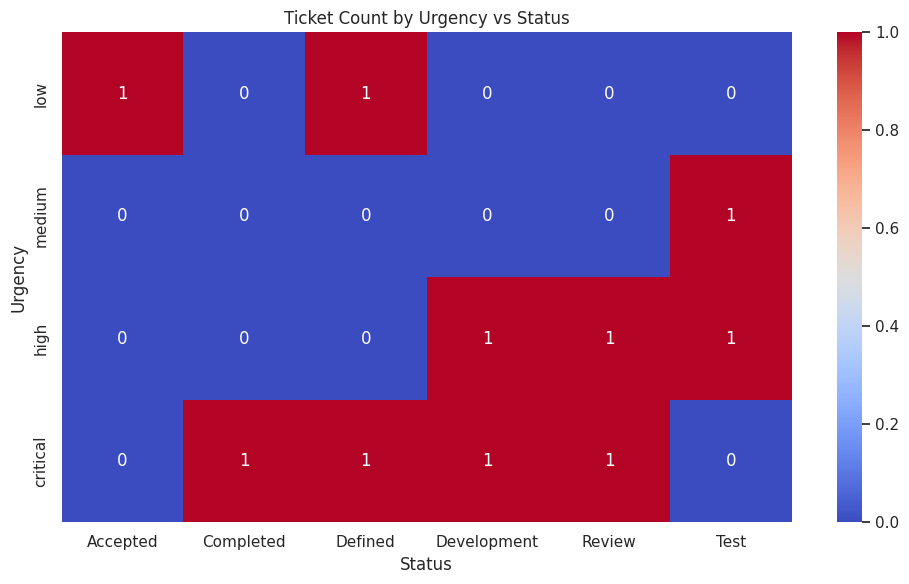

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create a pivot table of counts
heatmap_data = df.pivot_table(index='urgency', columns='status', aggfunc='size', fill_value=0)

# Plot
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='coolwarm')
plt.title('Ticket Count by Urgency vs Status')
plt.xlabel('Status')
plt.ylabel('Urgency')
plt.tight_layout()
plt.show()


<ipython-input-18-35409372>:2: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior



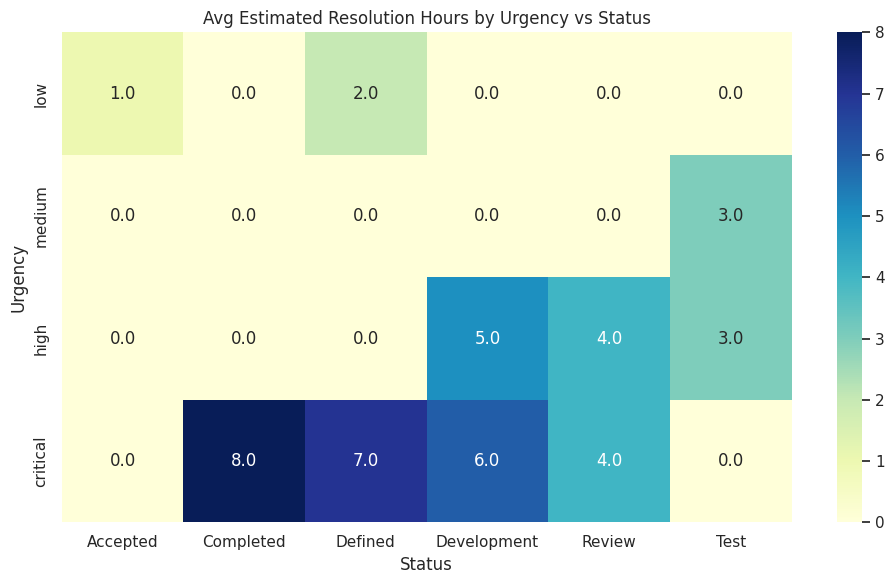

In [18]:
# Create pivot table of average estimated hours
duration_heatmap = df.pivot_table(index='urgency', columns='status', values='hours', aggfunc='mean', fill_value=0)

# Plot
plt.figure(figsize=(10, 6))
sns.heatmap(duration_heatmap, annot=True, fmt='.1f', cmap='YlGnBu')
plt.title('Avg Estimated Resolution Hours by Urgency vs Status')
plt.xlabel('Status')
plt.ylabel('Urgency')
plt.tight_layout()
plt.show()
